In [10]:
import json
import simpledorff
from collections import defaultdict, Counter
from pprint import pprint
import numpy as np
import itertools

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau

DATA_FILE = '../data/processed_data_w_metrics.json'
SUBMISSION_FILE = '../data/submission_info.json'

data = []
with open(DATA_FILE, 'r') as f:
    for line in f:
        data.append(json.loads(line))
        
with open(SUBMISSION_FILE, 'r') as f:
    submissions = json.load(f)


In [11]:
cochrane = [d for d in data if d['subtask'] == 'Cochrane']
ms2 = [d for d in data if d['subtask'] == 'MS2']

cochrane_annot = [d for d in cochrane if any(entry['annotations'] for entry in d['predictions'])]
ms2_annot = [d for d in ms2 if any(entry['annotations'] for entry in d['predictions'])]

cochrane_metrics = [d for d in cochrane if any(entry['scores'] for entry in d['predictions'])]
ms2_metrics = [d for d in ms2 if any(entry['scores'] for entry in d['predictions'])]

print('Cochrane: ', len(cochrane))
print('w/ annotations: ', len(cochrane_annot))
print('w/ metrics: ', len(cochrane_metrics))
print()

print('MS2: ', len(ms2))
print('w/ annotations: ', len(ms2_annot))
print('w/ metrics: ', len(ms2_metrics))


Cochrane:  470
w/ annotations:  274
w/ metrics:  470

MS2:  1667
w/ annotations:  0
w/ metrics:  1667


In [39]:
data_to_analyze = []
for entry in cochrane:
    for pred in entry['predictions']:
        data_entry = {
            'review_id': entry['review_id'],
            'exp_id': pred['exp_short'],
            'exp_name': submissions[pred['exp_short']]['name']
        }
        annot_dict = dict()
        annot_dict['annotated'] = False
        if pred['annotations']:
            annot = pred['annotations'][0]
            if not annot['population']:
                annot['population'] = 0
            if not annot['intervention']:
                annot['intervention'] = 0
            if not annot['outcome']:
                annot['outcome'] = 0
            if not annot['ed_target']:
                annot['ed_target'] = -1
            if not annot['ed_generated']:
                annot['ed_generated'] = -1
            if not annot['strength_target']:
                annot['strength_target'] = 0
            if not annot['strength_generated']:
                annot['strength_generated'] = 0
            annot_dict = {
                'annot_id': annot['annot_id'],
                'fluency_normalized': annot['fluency'] / 2.0,
                'pio_normalized': (annot['population'] + annot['intervention'] + annot['outcome']) / 6.0,
                'ed_normalized': (2.0 - abs(abs(annot.get('ed_target')) - abs(annot.get('ed_generated')))) / 2.0,
                'strength_normalized': (3.0 - (abs(annot.get('strength_target')) - abs(annot.get('strength_generated')))) / 3.0
            }
            annot_dict['annot_all'] = np.mean([
                annot_dict['fluency_normalized'], 
                annot_dict['pio_normalized'], 
                annot_dict['ed_normalized'], 
                annot_dict['strength_normalized']
            ])
            annot_dict['annotated'] = True
        score_dict = dict()
        score_dict['scored'] = False
        if pred['scores']:
            score_dict = {
                'rouge_avg_f': np.mean([
                    pred['scores']['rouge1_f'],
                    pred['scores']['rouge2_f'],
                    pred['scores']['rougeL_f']
                ]),
                'rougeLsum_f': pred['scores']['rougeLsum_f'],
                'bertscore_f': pred['scores']['bertscore_f'] if pred['scores']['bertscore_f'] > 0.5 else None,
                'ei_score': pred['scores']['ei_score'],
                'claimver': pred['scores']['claimver'],
                'sts': pred['scores']['sts'],
                'nli': pred['scores']['nli']            
            }
            score_dict['scored'] = True
        data_entry.update(annot_dict)
        data_entry.update(score_dict)
        data_to_analyze.append(data_entry)


In [40]:
print('Number entries: ', len(data_to_analyze))
print('Number annotated: ', len([entry for entry in data_to_analyze if entry['annotated']]))
print('Number scored: ', len([entry for entry in data_to_analyze if entry['scored']]))


Number entries:  4658
Number annotated:  597
Number scored:  4654


In [27]:
EXP_W_ANNOTS = set([entry['exp_id'] for entry in data_to_analyze if entry['annotated']])
pprint([submissions[exp]['name'] for exp in EXP_W_ANNOTS])

['SciSpace',
 'led-base-16384-cochrane',
 'AI2/BART/train Cochrane/decode Cochrane',
 'bart-large-finetuned',
 'ittc1',
 'ittc2']


In [41]:
data_to_analyze = [entry for entry in data_to_analyze if entry['exp_id'] in EXP_W_ANNOTS]
df = pd.DataFrame.from_records(data_to_analyze)
display(df)

,review_id,exp_id,exp_name,annot_id,fluency_normalized,pio_normalized,ed_normalized,strength_normalized,annot_all,annotated,rouge_avg_f,rougeLsum_f,bertscore_f,ei_score,claimver,sts,nli,scored
0,CD000220,SPNXTA,led-base-16384-cochrane,0.0,0.5,0.833333,1.0,1.000000,0.833333,True,0.143460,0.126582,0.820654,0.548843,0.388424,0.308657,0.481221,True
1,CD000220,8FWF5T,SciSpace,0.0,1.0,0.333333,0.5,0.333333,0.541667,True,0.085714,0.114286,0.840982,0.382199,0.091838,0.324911,0.438535,True
2,CD000220,JB6Z8F,ittc2,0.0,1.0,1.000000,0.5,0.333333,0.708333,True,0.140126,0.172840,0.861498,0.378377,0.567364,0.709927,0.744722,True
3,CD000220,AQ85CE,bart-large-finetuned,0.0,1.0,0.833333,1.0,1.000000,0.958333,True,0.126847,0.137931,0.892283,0.382296,0.816214,0.609254,0.590197,True
4,CD000220,VNCH8M,ittc1,0.0,1.0,0.333333,0.5,0.333333,0.541667,True,0.025641,0.038462,0.847631,0.652080,0.496744,0.483377,0.465384,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2807,CD004979,8FWF5T,SciSpace,NaN,NaN,NaN,NaN,NaN,NaN,False,0.081761,0.094340,0.834069,0.073189,0.699197,0.578380,0.645646,True
2808,CD004979,JB6Z8F,ittc2,NaN,NaN,NaN,NaN,NaN,NaN,False,0.071895,0.078431,0.841421,0.073205,0.580660,0.622083,0.671254,True
2809,CD004979,AQ85CE,bart-large-finetuned,NaN,NaN,NaN,NaN,NaN,NaN,False,0.080997,0.093458,0.839404,0.072093,0.552418,0.618587,0.693284,True
2810,CD004979,VNCH8M,ittc1,NaN,NaN,NaN,NaN,NaN,NaN,False,0.114024,0.121951,0.844415,0.885757,0.636500,0.680110,0.771536,True


In [42]:
df_annot = df[df['annotated'] == True]
display(df_annot)

,review_id,exp_id,exp_name,annot_id,fluency_normalized,pio_normalized,ed_normalized,strength_normalized,annot_all,annotated,rouge_avg_f,rougeLsum_f,bertscore_f,ei_score,claimver,sts,nli,scored
0,CD000220,SPNXTA,led-base-16384-cochrane,0.0,0.5,0.833333,1.0,1.000000,0.833333,True,0.143460,0.126582,0.820654,0.548843,0.388424,0.308657,0.481221,True
1,CD000220,8FWF5T,SciSpace,0.0,1.0,0.333333,0.5,0.333333,0.541667,True,0.085714,0.114286,0.840982,0.382199,0.091838,0.324911,0.438535,True
2,CD000220,JB6Z8F,ittc2,0.0,1.0,1.000000,0.5,0.333333,0.708333,True,0.140126,0.172840,0.861498,0.378377,0.567364,0.709927,0.744722,True
3,CD000220,AQ85CE,bart-large-finetuned,0.0,1.0,0.833333,1.0,1.000000,0.958333,True,0.126847,0.137931,0.892283,0.382296,0.816214,0.609254,0.590197,True
4,CD000220,VNCH8M,ittc1,0.0,1.0,0.333333,0.5,0.333333,0.541667,True,0.025641,0.038462,0.847631,0.652080,0.496744,0.483377,0.465384,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2801,CD003412,8FWF5T,SciSpace,1.0,0.5,0.500000,0.5,0.666667,0.541667,True,0.137842,0.152174,0.870046,0.015699,0.820657,0.727004,0.704339,True
2802,CD003412,JB6Z8F,ittc2,1.0,1.0,0.166667,0.5,0.666667,0.583333,True,0.143842,0.150538,0.867927,0.006715,0.807963,0.801339,0.795298,True
2803,CD003412,AQ85CE,bart-large-finetuned,1.0,1.0,0.333333,1.0,1.000000,0.833333,True,0.168992,0.197802,0.871990,0.004625,0.799416,0.806493,0.788742,True
2804,CD003412,VNCH8M,ittc1,1.0,0.0,0.333333,0.5,0.666667,0.375000,True,0.094491,0.091667,0.823415,0.060127,0.652030,0.620651,0.685796,True


In [43]:
Counter(df_annot['exp_id'])

Counter({'SPNXTA': 100,
         '8FWF5T': 99,
         'JB6Z8F': 100,
         'AQ85CE': 98,
         'VNCH8M': 100,
         'PX7SGV': 100})

In [44]:
counts_per = defaultdict(int)
for rev_id, count in Counter(df_annot['review_id']).items():
    counts_per[count] += 1
    
pprint(counts_per)

defaultdict(<class 'int'>, {6: 50, 1: 162, 2: 52, 3: 9, 4: 1})


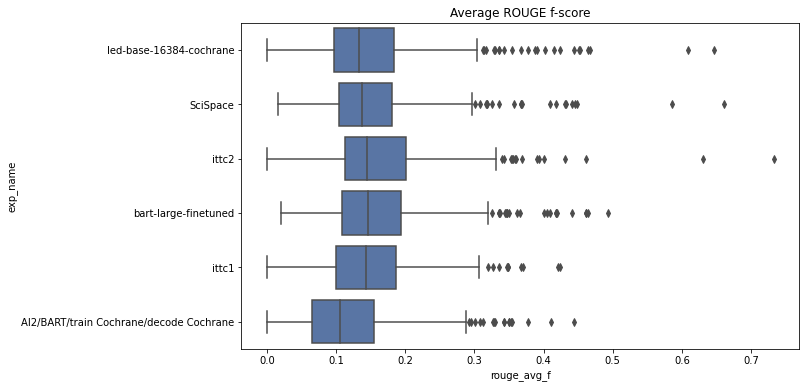

In [45]:
sns.set_color_codes()
pal = {exp: "b" for exp in df['exp_name'].unique()}
plt.figure(figsize=(10,6))
sns.boxplot(data=df, y="exp_name", x="rouge_avg_f", palette=pal)
plt.title('Average ROUGE f-score')
plt.show()

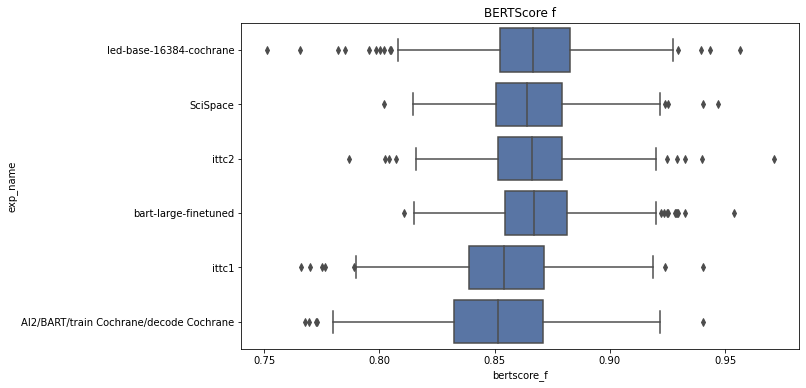

In [46]:
sns.set_color_codes()
pal = {exp: "b" for exp in df['exp_name'].unique()}
plt.figure(figsize=(10,6))
sns.boxplot(data=df, y="exp_name", x="bertscore_f", palette=pal)
plt.title('BERTScore f')
plt.show()

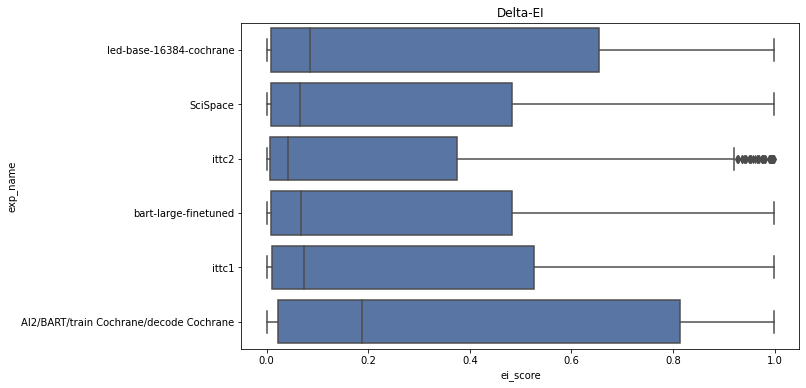

In [47]:
sns.set_color_codes()
pal = {exp: "b" for exp in df['exp_name'].unique()}
plt.figure(figsize=(10,6))
sns.boxplot(data=df, y="exp_name", x="ei_score", palette=pal)
plt.title('Delta-EI')
plt.show()

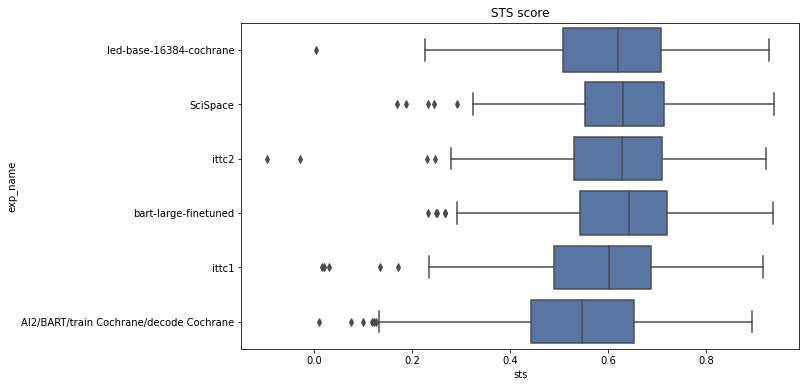

In [48]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, y="exp_name", x="sts", palette=pal)
plt.title('STS score')
plt.show()

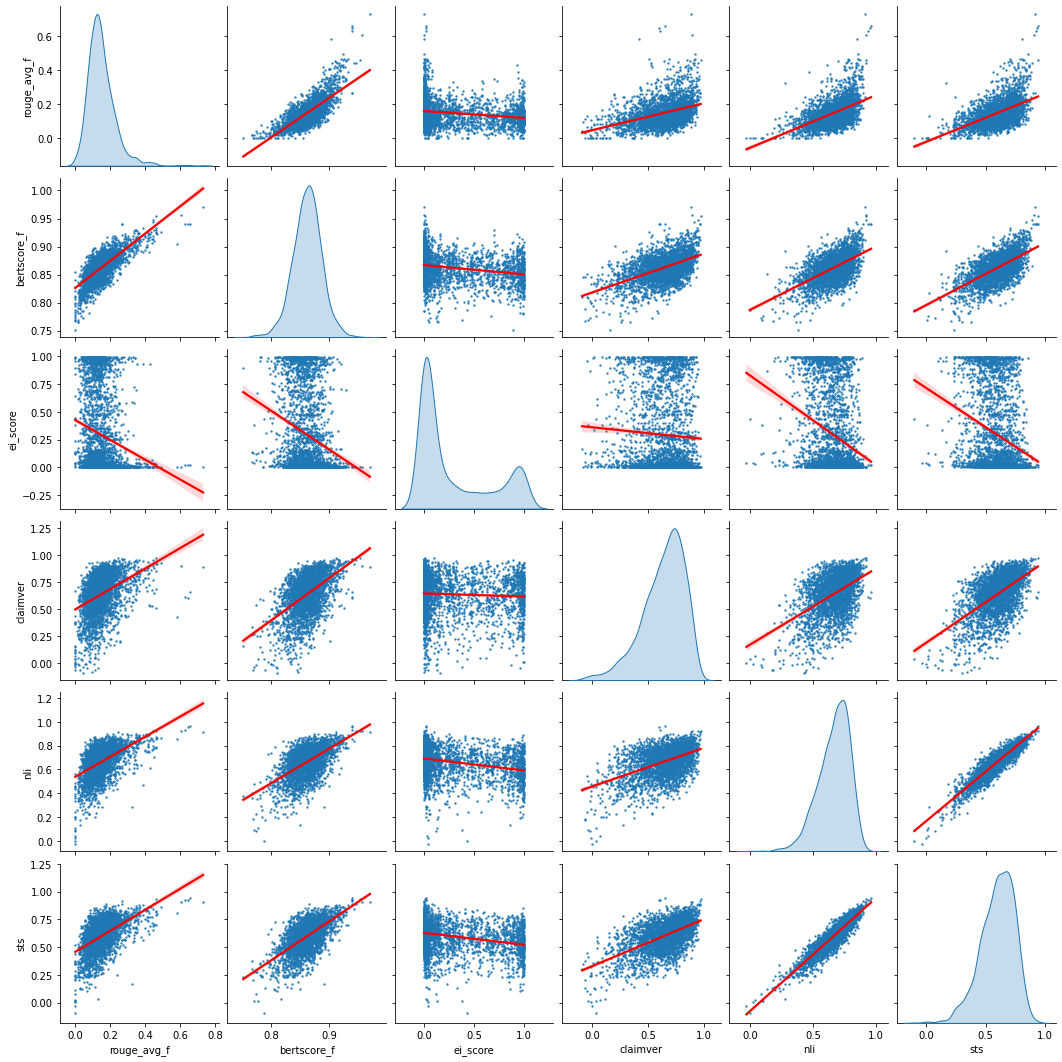

In [49]:
sns.pairplot(
    df, 
#     hue="exp_name",
    x_vars=["rouge_avg_f", "bertscore_f", "ei_score", "claimver", "nli", "sts"],
    y_vars=["rouge_avg_f", "bertscore_f", "ei_score", "claimver", "nli", "sts"],
    diag_kind="kde",
#     kind="scatter",
#     palette="muted",
    kind="reg", 
    plot_kws={
        'line_kws':{'color':'red'},
        'scatter_kws': {'s': 2}
    }
)
plt.show()

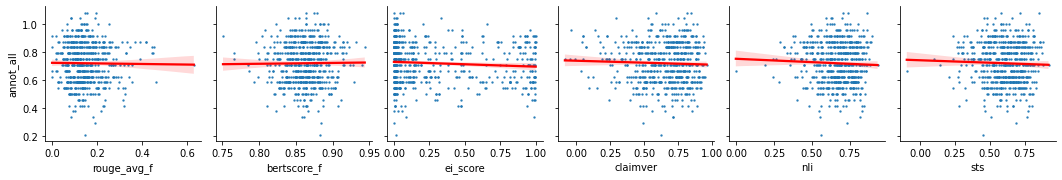

In [50]:
sns.pairplot(
    df_annot, 
#     hue="exp_name",
    diag_kind="kde",
    x_vars=["rouge_avg_f", "bertscore_f", "ei_score", "claimver", "nli", "sts"],
    y_vars=[
#         "fluency_normalized", "pio_normalized", "ed_normalized", "strength_normalized", 
        "annot_all"
    ],
#     kind="scatter",
#     palette="muted",
    kind="reg", 
    plot_kws={
        'line_kws':{'color':'red'},
        'scatter_kws': {'s': 2}
    }
)
plt.show()

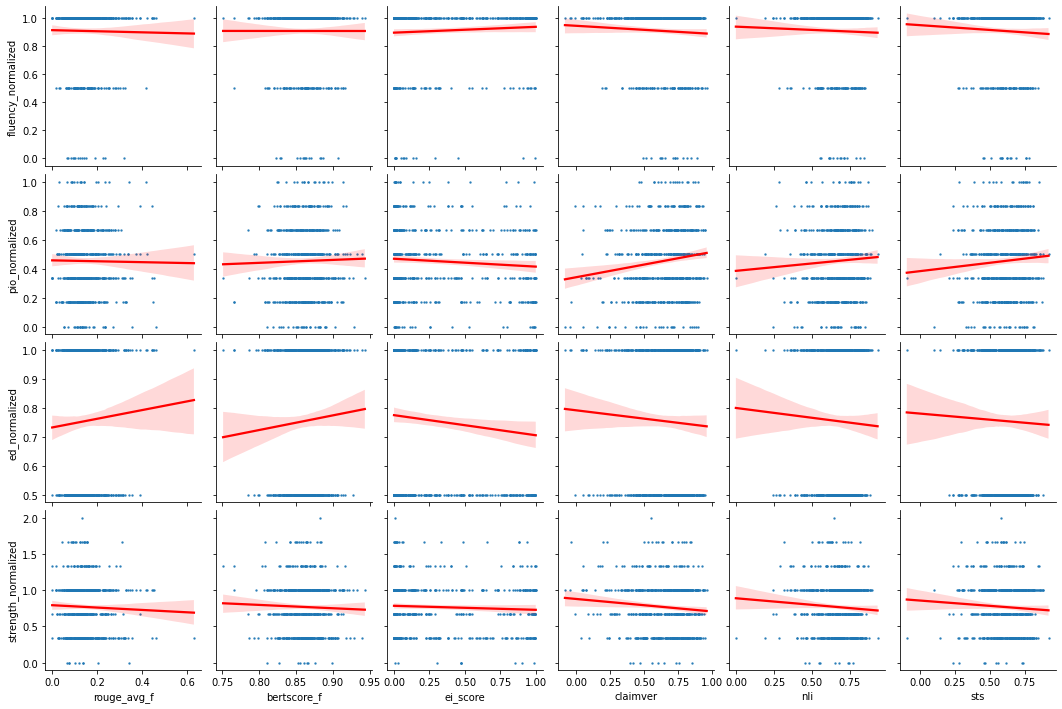

In [51]:
sns.pairplot(
    df_annot, 
#     hue="exp_name",
    x_vars=["rouge_avg_f", "bertscore_f", "ei_score", "claimver", "nli", "sts"],
    y_vars=[
        "fluency_normalized", 
        "pio_normalized", 
        "ed_normalized", 
        "strength_normalized", 
#         "annot_all"
    ],
#     kind="scatter",
#     kind="kde",
#     palette="muted"
    kind="reg", 
    plot_kws={
        'line_kws':{'color':'red'},
        'scatter_kws': {'s': 2}
    }
)
plt.show()

In [52]:
score_keys = [
    'rouge_avg_f',
    'ei_score',
    'claimver',
    'nli',
    'sts'
]

annot_keys = [
    'annot_all',
    'fluency_normalized',
    'pio_normalized',
    'ed_normalized',
    'strength_normalized'
]

corr_vals = []
for score_k, annot_k in itertools.product(score_keys, annot_keys):
    p_r, p_p = pearsonr(df_annot[score_k], df_annot[annot_k])
    s_r, s_p = spearmanr(df_annot[score_k], df_annot[annot_k])
    k_t, k_p = kendalltau(df_annot[score_k], df_annot[annot_k])
    corr_vals.append({
        'score': score_k,
        'annot': annot_k,
        'p_r': p_r,
        'p_p': p_p,
        's_r': s_r,
        's_p': s_p,
        'k_t': k_t,
        'k_p': k_p
    })


In [53]:
[entry for entry in corr_vals if entry['annot'] == 'pio_normalized']

[{'score': 'rouge_avg_f',
  'annot': 'pio_normalized',
  'p_r': -0.010119213215406467,
  'p_p': 0.8051119488228281,
  's_r': -0.00959227298812815,
  's_p': 0.8150721018099445,
  'k_t': -0.00692743357252239,
  'k_p': 0.815839201222824},
 {'score': 'ei_score',
  'annot': 'pio_normalized',
  'p_r': -0.0796987919917973,
  'p_p': 0.05161358104345769,
  's_r': -0.05858782723469797,
  's_p': 0.15279203349885828,
  'k_t': -0.04295660245430153,
  'k_p': 0.14863914593940936},
 {'score': 'claimver',
  'annot': 'pio_normalized',
  'p_r': 0.14212002351176134,
  'p_p': 0.0004959802378006065,
  's_r': 0.14180151047097736,
  's_p': 0.0005107917844371905,
  'k_t': 0.10411832525208065,
  'k_p': 0.0004638091907595441},
 {'score': 'nli',
  'annot': 'pio_normalized',
  'p_r': 0.053136933357888876,
  'p_p': 0.19479614947050986,
  's_r': 0.05805860648473803,
  's_p': 0.15654082541087497,
  'k_t': 0.04278203280717229,
  'k_p': 0.15029639731149633},
 {'score': 'sts',
  'annot': 'pio_normalized',
  'p_r': 0.066

In [60]:
annot_order = df_annot.groupby(by=["exp_id"])["annot_all"].mean().sort_values(ascending=False)
pio_order = df_annot.groupby(by=["exp_id"])["pio_normalized"].mean().sort_values(ascending=False)
rouge_order = df_annot.groupby(by=["exp_id"])["rouge_avg_f"].mean().sort_values(ascending=False)
eid_order = df_annot.groupby(by=["exp_id"])["ei_score"].mean().sort_values(ascending=True)

# for a, p, r, e in zip(annot_order, pio_order, rouge_order, eid_order):
#     print(a, p, r, e)
print(annot_order)
print(pio_order)
print(rouge_order)
print(eid_order)




exp_id
SPNXTA    0.797917
VNCH8M    0.776250
AQ85CE    0.749150
PX7SGV    0.693333
JB6Z8F    0.687917
8FWF5T    0.616582
Name: annot_all, dtype: float64
exp_id
VNCH8M    0.516667
SPNXTA    0.483333
PX7SGV    0.440000
JB6Z8F    0.433333
AQ85CE    0.423469
8FWF5T    0.412458
Name: pio_normalized, dtype: float64
exp_id
JB6Z8F    0.167245
8FWF5T    0.159802
AQ85CE    0.152054
SPNXTA    0.146111
VNCH8M    0.144164
PX7SGV    0.126785
Name: rouge_avg_f, dtype: float64
exp_id
JB6Z8F    0.207814
AQ85CE    0.244611
8FWF5T    0.251985
VNCH8M    0.283077
SPNXTA    0.320848
PX7SGV    0.427931
Name: ei_score, dtype: float64
